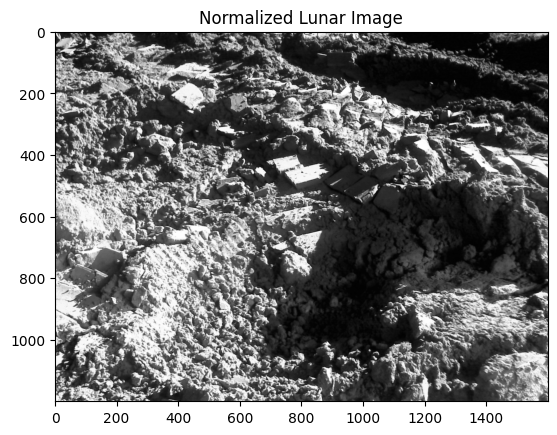

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load grayscale image
img = cv2.imread(r'C:\Users\Bhakti\Documents\Projects\LunaShape\data\rim\data\calibrated\20230831\ch3_rim_nc1_20230831T2202457723_d_img_gnh_2_0.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float32)

# Normalize to [0,1]
img_norm = (img - img.min()) / (img.max() - img.min())

plt.imshow(img_norm, cmap='gray')
plt.title('Normalized Lunar Image')
plt.show()


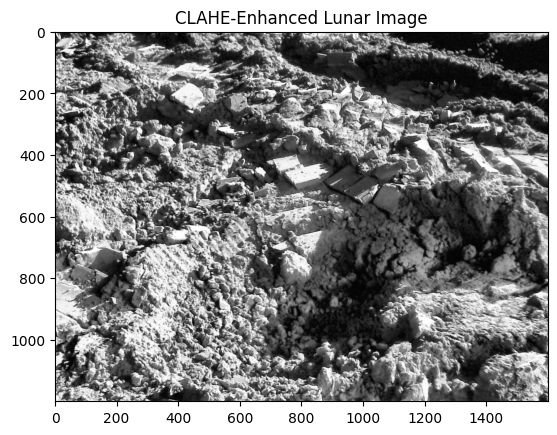

Iteration 0, MSE: 0.094879
Iteration 10, MSE: 0.094737
Iteration 20, MSE: 0.094851
Iteration 30, MSE: 0.096196
Iteration 40, MSE: 0.098280


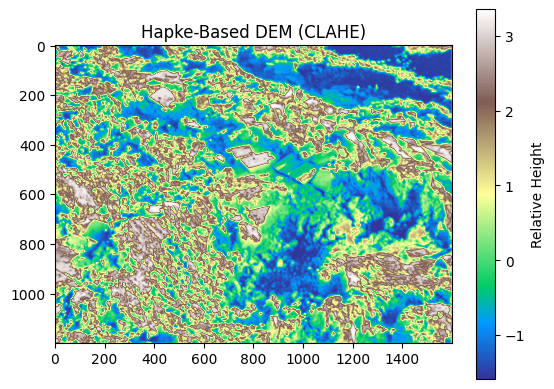

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ----------------------------
# Step 1: Load image (grayscale)
# ----------------------------
img = cv2.imread(
    r'C:\Users\Bhakti\Documents\Projects\LunaShape\data\rim\data\calibrated\20230831\ch3_rim_nc1_20230831T2202457723_d_img_gnh_2_0.jpg',
    cv2.IMREAD_GRAYSCALE
).astype(np.float32)

# ----------------------------
# Apply CLAHE (local contrast enhancement)
# ----------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_uint8 = np.clip(img, 0, 255).astype(np.uint8)  # CLAHE needs 8-bit
img_corr = clahe.apply(img_uint8)
img_corr = img_corr.astype(np.float32) / 255.0      # convert back to float [0,1]

# Display CLAHE-enhanced image
plt.imshow(img_corr, cmap='gray')
plt.title('CLAHE-Enhanced Lunar Image')
plt.show()

# ----------------------------
# Step 3: Hapke reflectance function
# ----------------------------
def hapke_reflectance(slope_x, slope_y, sun_vector, w=0.3, theta=20*np.pi/180):
    n = np.dstack((-slope_x, -slope_y, np.ones_like(slope_x)))
    n /= np.linalg.norm(n, axis=2, keepdims=True)
    cos_i = np.clip(np.sum(n * sun_vector, axis=2), 0, 1)
    I = w * cos_i / (cos_i + 0.01)  # avoid divide by zero
    I *= (1 + theta**2)
    return I

# ----------------------------
# Step 4: Initialize DEM
# ----------------------------
H, W = img_corr.shape
dem = np.zeros((H, W), dtype=np.float32)
slope_x = np.zeros_like(dem)
slope_y = np.zeros_like(dem)

# Sun vector example: 45 deg azimuth, 30 deg elevation
azimuth = 45*np.pi/180
elevation = 30*np.pi/180
sun_vector = np.array([np.cos(elevation)*np.cos(azimuth),
                       np.cos(elevation)*np.sin(azimuth),
                       np.sin(elevation)])
sun_vector /= np.linalg.norm(sun_vector)

# ----------------------------
# Step 5: Iterative DEM estimation
# ----------------------------
def estimate_dem(img, sun_vector, dem, lr=0.1, iterations=50):
    slope_x = np.zeros_like(dem)
    slope_y = np.zeros_like(dem)
    
    for it in range(iterations):
        slope_x[:-1, :] = dem[1:, :] - dem[:-1, :]
        slope_y[:, :-1] = dem[:, 1:] - dem[:, :-1]
        I_pred = hapke_reflectance(slope_x, slope_y, sun_vector)
        residual = img - I_pred
        dem[:-1, :-1] += lr * residual[:-1, :-1]
        if it % 10 == 0:
            mse = np.mean(residual**2)
            print(f"Iteration {it}, MSE: {mse:.6f}")
    return dem

dem_final = estimate_dem(img_corr, sun_vector, dem)

# ----------------------------
# Step 6: Smooth DEM
# ----------------------------
dem_smooth = gaussian_filter(dem_final, sigma=2)

plt.imshow(dem_smooth, cmap='terrain')
plt.colorbar(label='Relative Height')
plt.title('Hapke-Based DEM (CLAHE)')
plt.show()


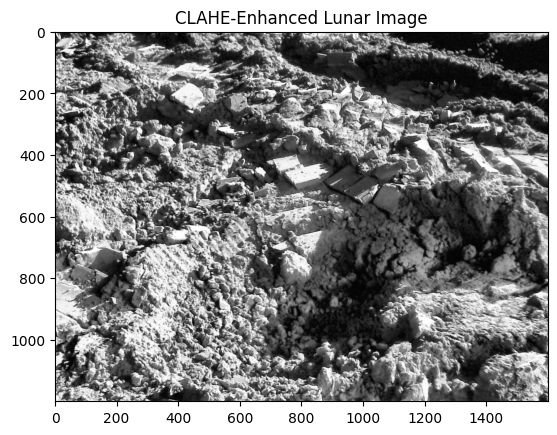

Iteration 0, MSE: 0.094879
Iteration 10, MSE: 0.094737
Iteration 20, MSE: 0.094851
Iteration 30, MSE: 0.096196
Iteration 40, MSE: 0.098280


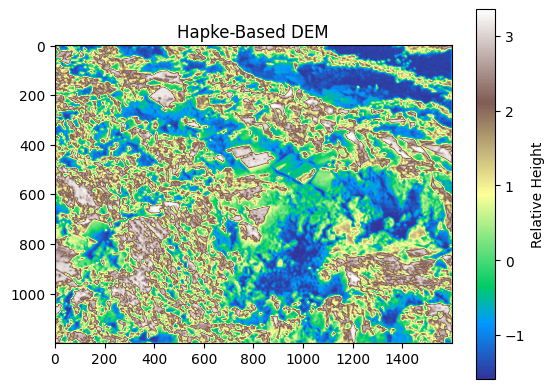

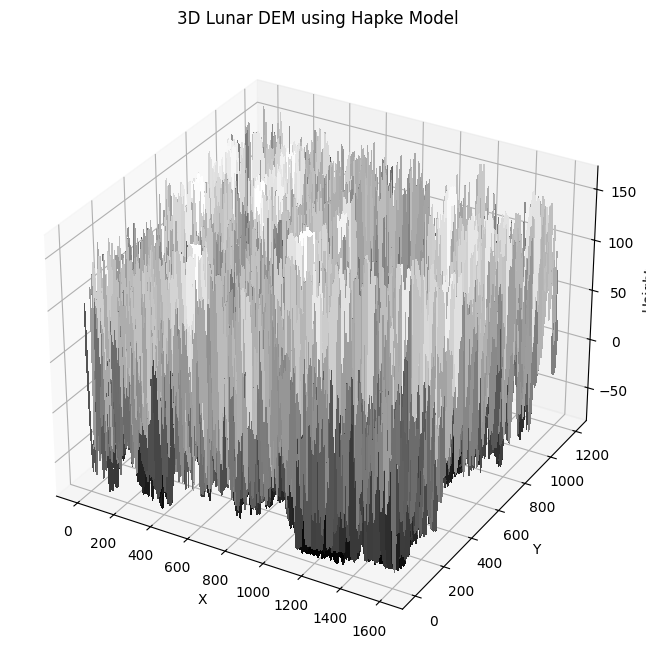

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ----------------------------
# Step 1: Load image (grayscale)
# ----------------------------
img = cv2.imread(
    r'C:\Users\Bhakti\Documents\Projects\LunaShape\data\rim\data\calibrated\20230831\ch3_rim_nc1_20230831T2202457723_d_img_gnh_2_0.jpg',
    cv2.IMREAD_GRAYSCALE
).astype(np.float32)

# ----------------------------
# Apply CLAHE (local contrast enhancement)
# ----------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_uint8 = np.clip(img, 0, 255).astype(np.uint8)  # CLAHE needs 8-bit
img_corr = clahe.apply(img_uint8)
img_corr = img_corr.astype(np.float32) / 255.0      # convert back to float [0,1]

# Display CLAHE-enhanced image
plt.imshow(img_corr, cmap='gray')
plt.title('CLAHE-Enhanced Lunar Image')
plt.show()

# ----------------------------
# Step 2: Hapke reflectance function
# ----------------------------
def hapke_reflectance(slope_x, slope_y, sun_vector, w=0.3, theta=20*np.pi/180):
    n = np.dstack((-slope_x, -slope_y, np.ones_like(slope_x)))
    n /= np.linalg.norm(n, axis=2, keepdims=True)
    cos_i = np.clip(np.sum(n * sun_vector, axis=2), 0, 1)
    I = w * cos_i / (cos_i + 0.01)  # avoid divide by zero
    I *= (1 + theta**2)
    return I

# ----------------------------
# Step 3: Initialize DEM
# ----------------------------
H, W = img_corr.shape
dem = np.zeros((H, W), dtype=np.float32)
slope_x = np.zeros_like(dem)
slope_y = np.zeros_like(dem)

# Sun vector example: 45 deg azimuth, 30 deg elevation
azimuth = 45*np.pi/180
elevation = 30*np.pi/180
sun_vector = np.array([np.cos(elevation)*np.cos(azimuth),
                       np.cos(elevation)*np.sin(azimuth),
                       np.sin(elevation)])
sun_vector /= np.linalg.norm(sun_vector)

# ----------------------------
# Step 4: Iterative DEM estimation
# ----------------------------
def estimate_dem(img, sun_vector, dem, lr=0.1, iterations=50):
    H, W = img.shape
    slope_x = np.zeros_like(dem)
    slope_y = np.zeros_like(dem)
    
    for it in range(iterations):
        slope_x[:-1, :] = dem[1:, :] - dem[:-1, :]
        slope_y[:, :-1] = dem[:, 1:] - dem[:, :-1]
        I_pred = hapke_reflectance(slope_x, slope_y, sun_vector)
        residual = img - I_pred
        dem[:-1, :-1] += lr * residual[:-1, :-1]
        if it % 10 == 0:
            mse = np.mean(residual**2)
            print(f"Iteration {it}, MSE: {mse:.6f}")
    return dem

dem_final = estimate_dem(img_corr, sun_vector, dem)

# ----------------------------
# Step 5: Smooth DEM
# ----------------------------
dem_smooth = gaussian_filter(dem_final, sigma=2)

plt.imshow(dem_smooth, cmap='terrain')
plt.colorbar(label='Relative Height')
plt.title('Hapke-Based DEM')
plt.show()


X, Y = np.meshgrid(np.arange(W), np.arange(H))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

# Scale heights for better visualization
scale = 50  # adjust for exaggeration
ax.plot_surface(X, Y, dem_smooth*scale, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title('3D Lunar DEM using Hapke Model')
plt.show()


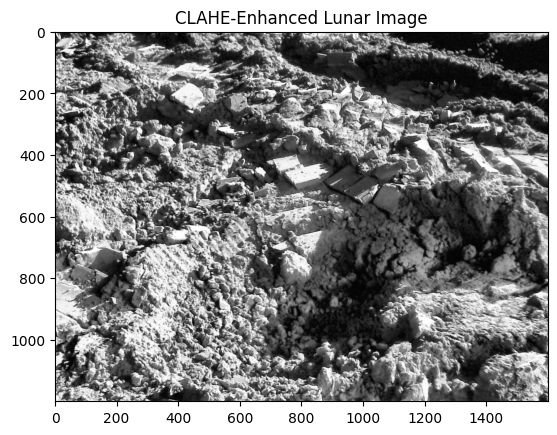

Iteration 0, MSE: 0.094879
Iteration 10, MSE: 0.094737
Iteration 20, MSE: 0.094851
Iteration 30, MSE: 0.096196
Iteration 40, MSE: 0.098280


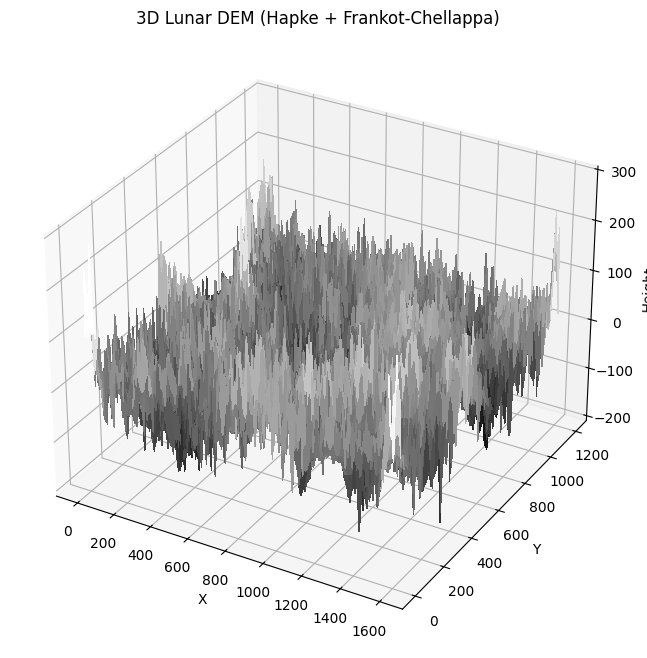

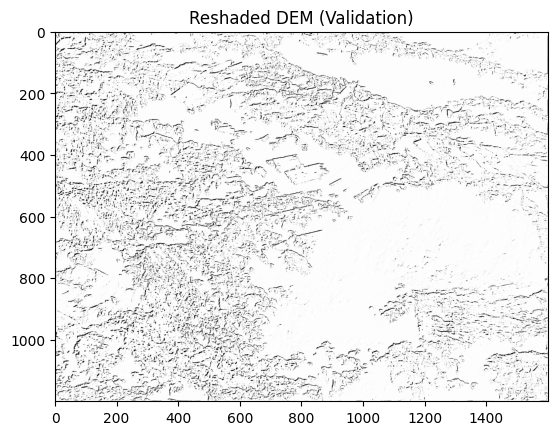

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, ifft2, fftfreq

# ----------------------------
# Step 1: Load image (grayscale)
# ----------------------------
img = cv2.imread(
    r'C:\Users\Bhakti\Documents\Projects\LunaShape\data\rim\data\calibrated\20230831\ch3_rim_nc1_20230831T2202457723_d_img_gnh_2_0.jpg',
    cv2.IMREAD_GRAYSCALE
).astype(np.float32)

# ----------------------------
# Apply CLAHE (local contrast enhancement)
# ----------------------------
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_uint8 = np.clip(img, 0, 255).astype(np.uint8)  # CLAHE needs 8-bit
img_corr = clahe.apply(img_uint8)
img_corr = img_corr.astype(np.float32) / 255.0      # convert back to float [0,1]

# Display CLAHE-enhanced image
plt.imshow(img_corr, cmap='gray')
plt.title('CLAHE-Enhanced Lunar Image')
plt.show()

# ----------------------------
# Step 2: Hapke reflectance function
# ----------------------------
def hapke_reflectance(slope_x, slope_y, sun_vector, w=0.3, theta=20*np.pi/180):
    n = np.dstack((-slope_x, -slope_y, np.ones_like(slope_x)))
    n /= np.linalg.norm(n, axis=2, keepdims=True)
    cos_i = np.clip(np.sum(n * sun_vector, axis=2), 0, 1)
    I = w * cos_i / (cos_i + 0.01)  # avoid division by zero
    I *= (1 + theta**2)
    return I

# ----------------------------
# Step 3: Initialize DEM and slopes
# ----------------------------
H, W = img_corr.shape
dem = np.zeros((H, W), dtype=np.float32)
slope_x = np.zeros_like(dem)
slope_y = np.zeros_like(dem)

# Sun vector (example: 45° azimuth, 30° elevation)
azimuth = 45*np.pi/180
elevation = 30*np.pi/180
sun_vector = np.array([np.cos(elevation)*np.cos(azimuth),
                       np.cos(elevation)*np.sin(azimuth),
                       np.sin(elevation)])
sun_vector /= np.linalg.norm(sun_vector)

# ----------------------------
# Step 4: Iterative slope estimation using Hapke
# ----------------------------
def estimate_slopes(img, sun_vector, dem, lr=0.1, iterations=50):
    slope_x = np.zeros_like(dem)
    slope_y = np.zeros_like(dem)
    
    for it in range(iterations):
        slope_x[:-1, :] = dem[1:, :] - dem[:-1, :]
        slope_y[:, :-1] = dem[:, 1:] - dem[:, :-1]
        
        I_pred = hapke_reflectance(slope_x, slope_y, sun_vector)
        residual = img - I_pred
        
        dem[:-1, :-1] += lr * residual[:-1, :-1]
        
        if it % 10 == 0:
            mse = np.mean(residual**2)
            print(f"Iteration {it}, MSE: {mse:.6f}")
    
    slope_x[:-1, :] = dem[1:, :] - dem[:-1, :]
    slope_y[:, :-1] = dem[:, 1:] - dem[:, :-1]
    
    return slope_x, slope_y

slope_x, slope_y = estimate_slopes(img_corr, sun_vector, dem)

# ----------------------------
# Step 5: Frankot-Chellappa integration
# ----------------------------
def frankot_chellappa(p, q):
    H, W = p.shape
    u = fftfreq(W).reshape(1, W)
    v = fftfreq(H).reshape(H, 1)
    
    P = fft2(p)
    Q = fft2(q)
    
    denom = (2j*np.pi*u)**2 + (2j*np.pi*v)**2
    denom[0,0] = 1  # avoid division by zero
    
    Z = (-1j*2*np.pi*u*P - 1j*2*np.pi*v*Q) / denom
    Z[0,0] = 0  # mean height 0
    z = np.real(ifft2(Z))
    return z

dem_fc = frankot_chellappa(slope_x, slope_y)
dem_fc_smooth = gaussian_filter(dem_fc, sigma=2)

# ----------------------------
# Step 6: 3D Visualization
# ----------------------------
X, Y = np.meshgrid(np.arange(W), np.arange(H))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
scale = 50  # exaggerate heights
ax.plot_surface(X, Y, dem_fc_smooth*scale, cmap='gray', linewidth=0, antialiased=False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Height')
ax.set_title('3D Lunar DEM (Hapke + Frankot-Chellappa)')
plt.show()

# ----------------------------
# Step 7: Optional Reshading for Validation
# ----------------------------
I_reshade = hapke_reflectance(slope_x, slope_y, sun_vector)
plt.imshow(I_reshade, cmap='gray')
plt.title('Reshaded DEM (Validation)')
plt.show()
